In [1]:
import skimage as img
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io as io
from skimage.morphology import skeletonize, medial_axis
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_peaks
from scipy.spatial import KDTree
from skimage.segmentation import active_contour
import numpy as np
from copy import deepcopy
plt.rcParams['figure.figsize'] = [20, 10]
from tqdm import tqdm
from os import path

In [2]:
# # disable tqdm if we want
# from functools import partialmethod
# tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [3]:
# %matplotlib widget

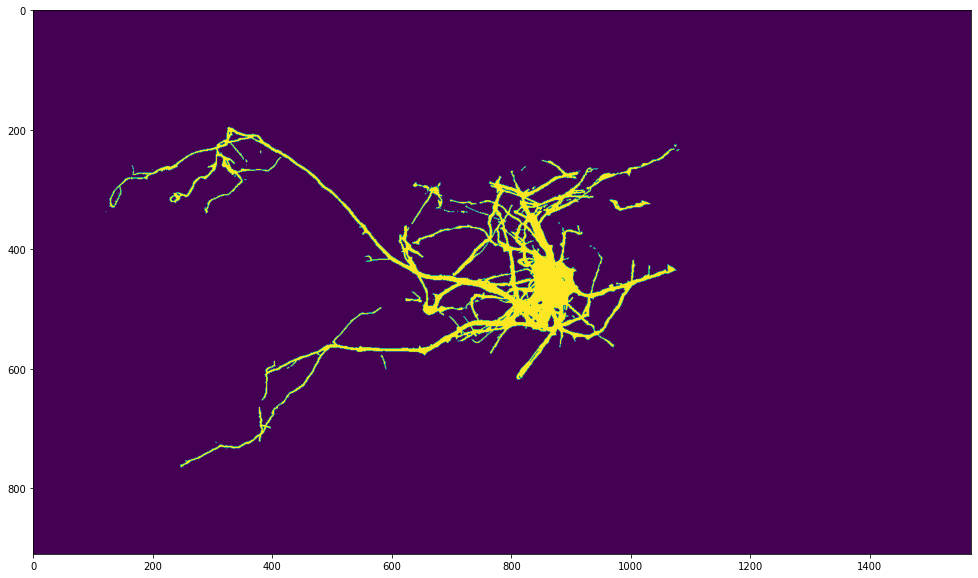

In [4]:
testimage = io.imread("data/capturetop.png")[:,:,:3]
testimage = (rgb2gray(testimage) > 0)
plt.imshow(testimage)
plt.show()

In [5]:
skel = skeletonize(testimage)

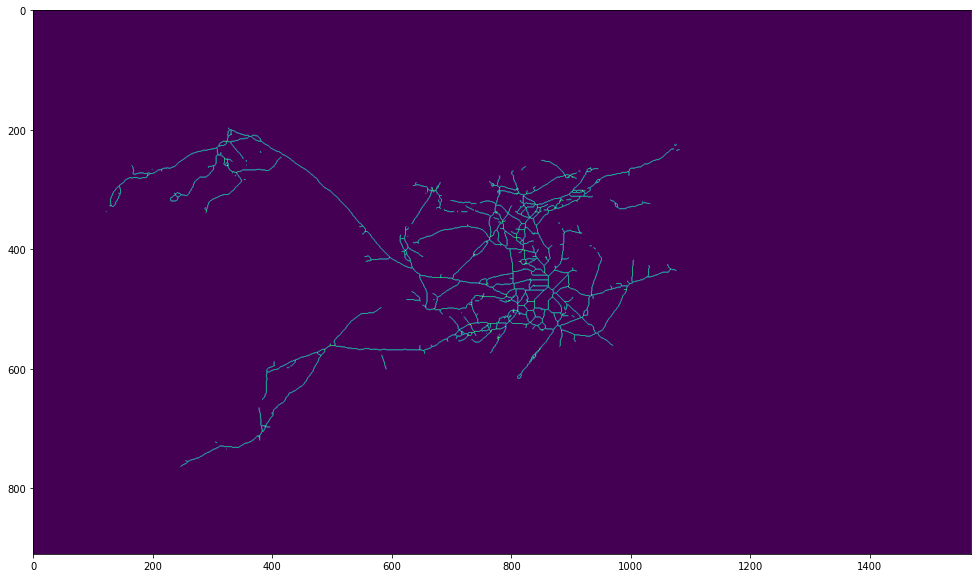

In [6]:
plt.imshow(skel)
plt.show()

In [7]:
med = medial_axis(testimage)

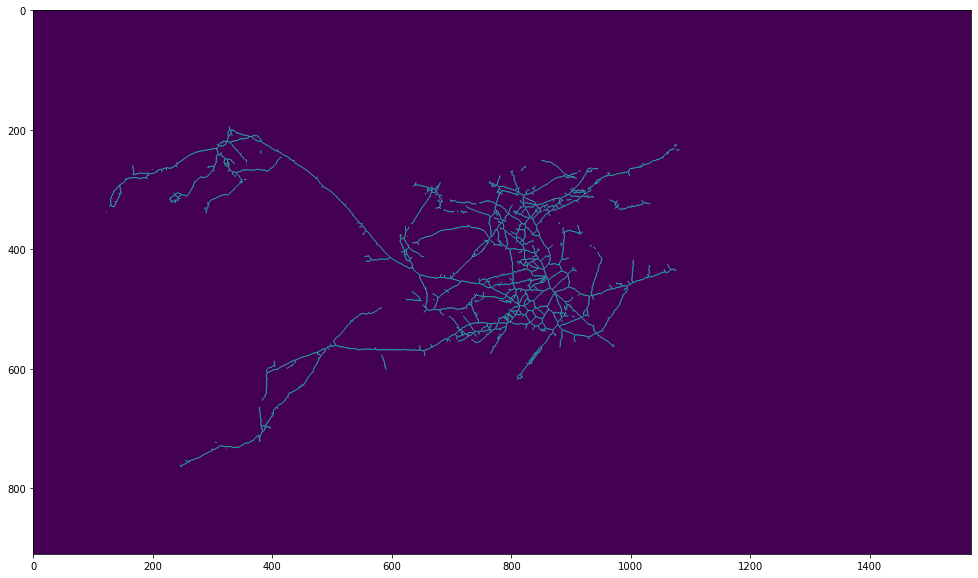

In [8]:
plt.imshow(med)
plt.show()

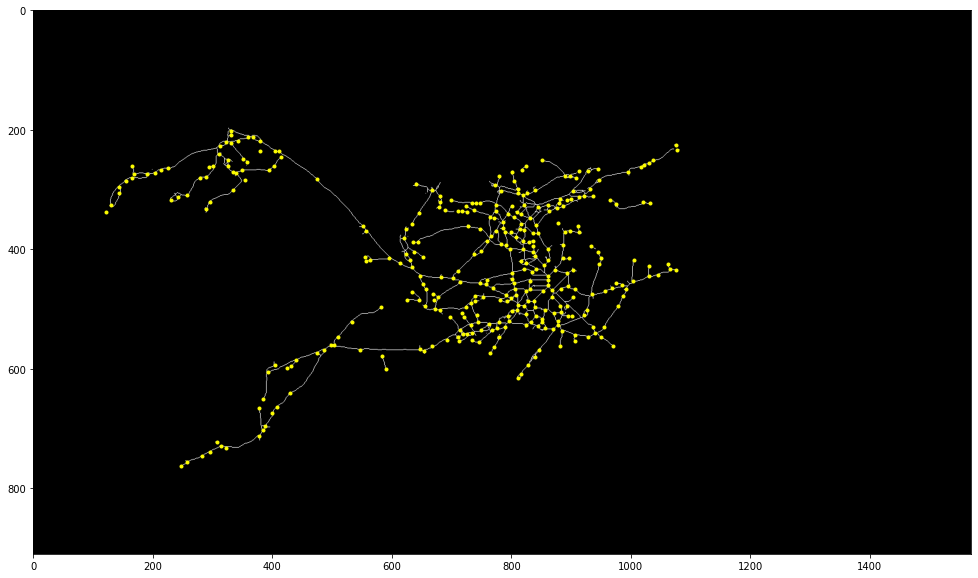

In [9]:
coords = corner_peaks(corner_harris(skel), min_distance=5, threshold_rel=0.01)

fig, ax = plt.subplots()
ax.imshow(skel, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='yellow', marker='o',
        linestyle='None', markersize=3)
plt.show()

728


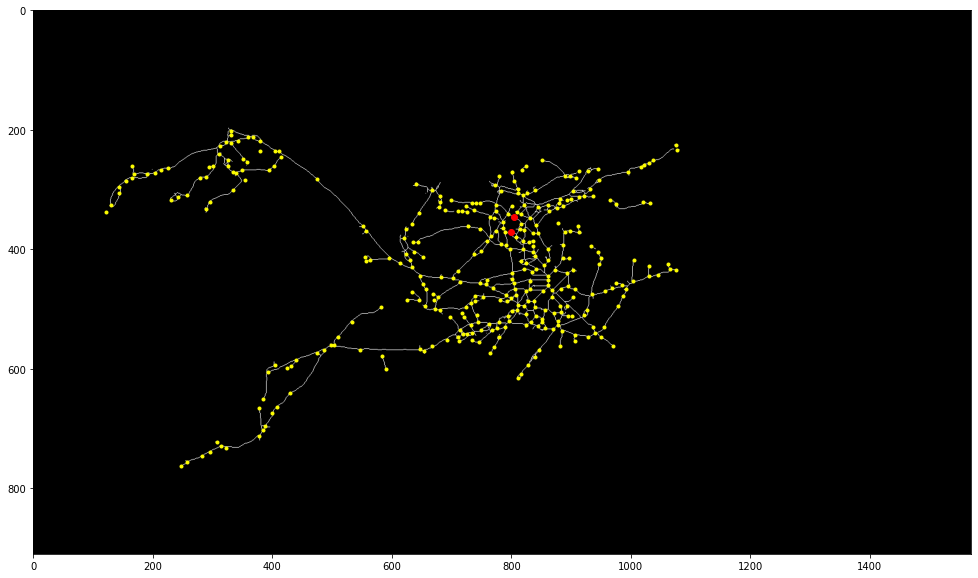

In [10]:
tree = KDTree(coords)
pairs = list(tree.query_pairs(25)) # Arbitrary max distance just for now
print(len(pairs))
pair1 = pairs[460] # Arbitrary number

neighbours = coords[pair1,]

fig, ax = plt.subplots()
ax.imshow(skel, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='yellow', marker='o',
        linestyle='None', markersize=3)
ax.plot(neighbours[:, 1], neighbours[:, 0], color='red', marker='o',
        linestyle='None', markersize=6)
plt.show()

In [11]:
# neighbours = np.array([[0,0], [50,50]]) # Definitely not a line
neighbours

array([[370, 800],
       [346, 805]])

In [12]:
pointlen = 10
r = np.linspace(neighbours[0][0], neighbours[1][0], pointlen)
c = np.linspace(neighbours[0][1], neighbours[1][1], pointlen)
init = np.array([r, c]).T

snake = active_contour(skel,
                       init, boundary_condition='fixed',
                       alpha=10.0, beta=10.0, w_line=5.0, w_edge=0, gamma=0.1)

snake = active_contour(gaussian(skel, 3, preserve_range=False),
                       init, boundary_condition='fixed',
                       alpha=0.1, beta=25.0, w_line=5.0, w_edge=0, gamma=0.1)

<ipython-input-12-fdc0e6f6cf66>:6: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  snake = active_contour(skel,
<ipython-input-12-fdc0e6f6cf66>:10: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  snake = active_contour(gaussian(skel, 3, preserve_range=False),


760.0 845.25 328.7 388.5


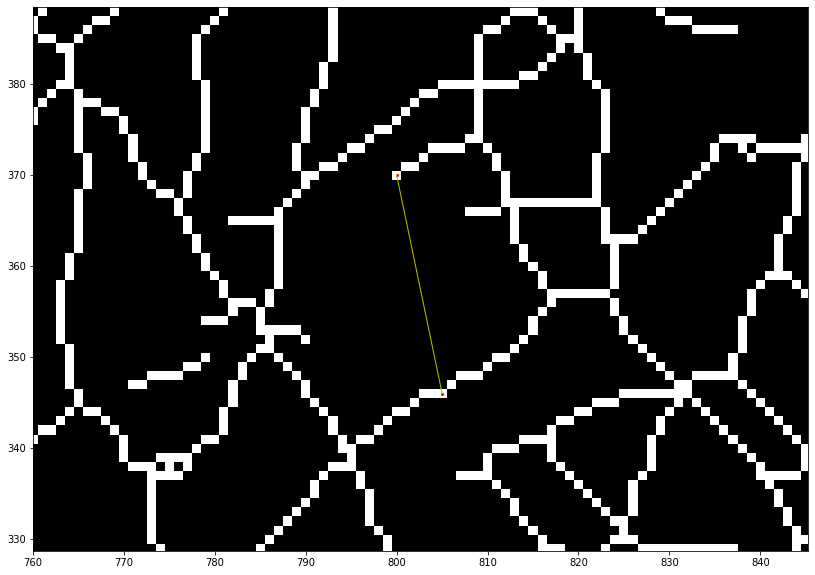

In [13]:
fig, ax = plt.subplots()
ax.imshow(skel, cmap=plt.cm.gray)
# ax.plot(coords[:, 1], coords[:, 0], color='yellow', marker='o',
#         linestyle='None', markersize=1)
ax.plot(neighbours[:, 1], neighbours[:, 0], color='red', marker='o',
        linestyle='None', markersize=2)
ax.plot(snake[:, 1], snake[:, 0], '-y', lw=1)

neighzip = list(zip(*neighbours))
x1 = min(neighzip[1]) * 0.95
x2 = max(neighzip[1]) * 1.05
y1 = min(neighzip[0]) * 0.95
y2 = max(neighzip[0]) * 1.05

print(x1, x2, y1, y2)

ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

# ax.indicate_inset_zoom(axins, edgecolor="black")
plt.show()

In [14]:
# this is MEANT to extract values along the line but I might have fucked up the order
snakeint = snake.astype("int")
np.count_nonzero(skel[snakeint[:,0], snakeint[:,1]]) / len(snake)

0.2

## TODO
- Snap all corners to a line
- Expand all lines (could probably just use the `gaussian` function with a kernel size of 1)
- Find output 
- Run spider web line traversal algorithm to traverse and find other nodes, this means we can keep the buffer zone super small (only 1 or two pixels probably)
- Can calulate end points and junction points
- If you have more junctions it is probably more complex!

https://stackoverflow.com/questions/74188111/is-there-a-way-to-join-nodes-of-a-network-based-upon-an-underlying-image

In [15]:
from skan import skeleton_to_csgraph
pixel_graph, coordinates = skeleton_to_csgraph(skel)

In [16]:
from skan import Skeleton, summarize
skanSkel = Skeleton(skel)
branch_data = summarize(skanSkel)
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,1,1,4,3.828427,1,1.0,0.0,197.0,327.0,200.0,329.0,197.0,327.0,200.0,329.0,3.605551
1,1,4,6,2.000000,2,1.0,0.0,200.0,329.0,200.0,331.0,200.0,329.0,200.0,331.0,2.000000
2,1,4,62,12.071068,2,1.0,0.0,200.0,329.0,210.0,326.0,200.0,329.0,210.0,326.0,10.440307
3,1,6,71,35.142136,2,1.0,0.0,200.0,331.0,211.0,361.0,200.0,331.0,211.0,361.0,31.953091
4,1,6,35,7.000000,2,1.0,0.0,200.0,331.0,207.0,331.0,200.0,331.0,207.0,331.0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1,8020,8019,1.000000,1,1.0,0.0,714.0,379.0,714.0,378.0,714.0,379.0,714.0,378.0,1.000000
749,1,8020,8031,5.000000,1,1.0,0.0,714.0,379.0,719.0,379.0,714.0,379.0,719.0,379.0,5.000000
750,36,8035,8039,2.414214,0,1.0,0.0,722.0,305.0,723.0,307.0,722.0,305.0,723.0,307.0,2.236068
751,1,8139,8146,3.828427,1,1.0,0.0,753.0,255.0,755.0,258.0,753.0,255.0,755.0,258.0,3.605551


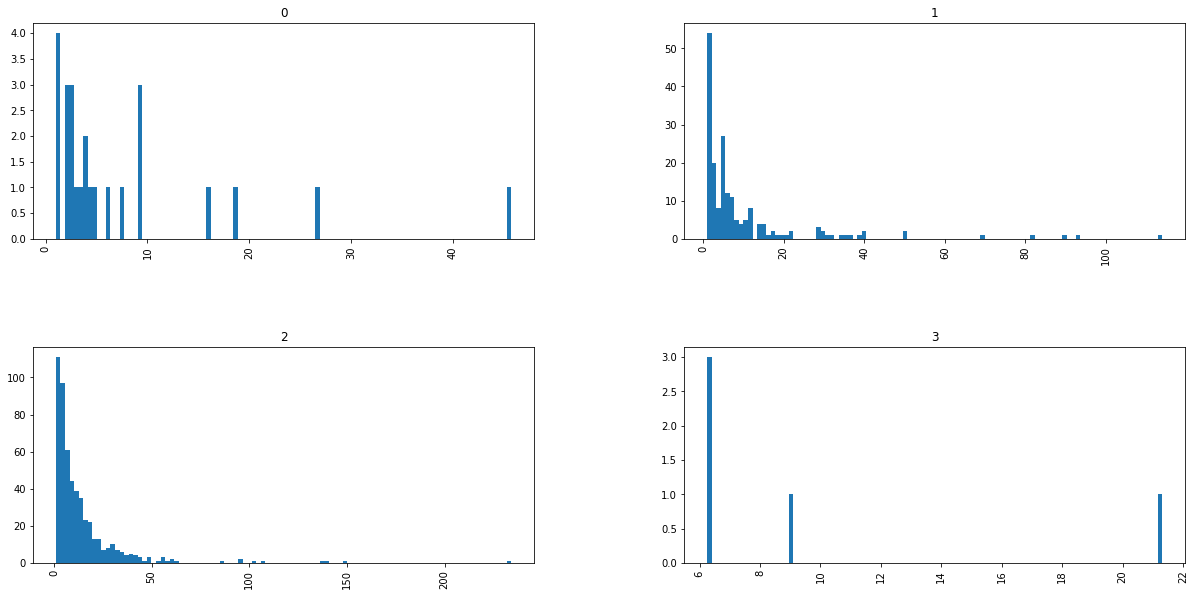

In [17]:
branch_data.hist(column='branch-distance', by='branch-type', bins=100);

In [18]:
import networkx as nx

In [19]:
net = nx.from_scipy_sparse_matrix(pixel_graph)

## Roll my own for now

In [20]:
# Get indices of all true pixels
whitepx = np.transpose(skel.nonzero())
# This is y, x

whitepx[0]

array([197, 327])

In [21]:
skel[17:20, 1318:1321]

array([[False, False, False],
       [False, False, False],
       [False, False, False]])

In [22]:
y = whitepx[0][0]
x = whitepx[0][1]
skel[y-1:y+2, x-1:x+2]

array([[False, False, False],
       [False,  True, False],
       [False,  True, False]])

In [23]:
def get_3x3(image, y, x, flatten=False):
    
    edgedict = {
        "top": [[0, 2, 1, 2], [1,0]],    # Get a 3x2 matrix, then overlay that over point [r=1, c=0] on a 3x3 zeros mat
        "bottom": [[1, 1, 1, 2], [0,0]],
        "left": [[1, 2, 0, 2], [0,1]],
        "right": [[1, 2, 1, 1], [0,0]],
        "topleft": [[0, 2, 0, 2], [1,1]],
        "topright": [[0, 2, 1, 1], [1,0]],
        "bottomleft": [[1, 1, 0, 2], [0,1]],
        "bottomright": [[1, 1, 1, 1], [0,0]]
    }

    
    # Detect if we are on an edge and construct a string that describes it
    yedge = ""
    xedge = ""
    if y == 0:
        yedge = "top"
    elif y == image.shape[0] - 1:
        yedge = "bottom"
    
    if x == 0:
        xedge = "left"
    elif x == image.shape[1] - 1:
        xedge = "right"
    
    edgepos = yedge + xedge
    
    if edgepos:
        # Look up ylo, yhi, xlo, xhi, and coords in dict of lists
        deltas, coords = edgedict[edgepos]
        # Deepcopy submat to make sure when we do temporary editing later, we don't modify the original image
        # This could be a bit slow so might be worth finding another way to do it
        submat = deepcopy(image[y-deltas[0]:y+deltas[1], x-deltas[2]:x+deltas[3]])
        finalmat = np.zeros((3, 3), dtype=bool)
        finalmat[coords[0]:coords[0]+submat.shape[0], coords[1]:coords[1]+submat.shape[1]] = submat
    else:
        finalmat = np.copy(image[y-1:y+2, x-1:x+2])
    
    if flatten:
        return finalmat.flatten()
    else:
        return finalmat

print(np.count_nonzero(get_3x3(skel, *whitepx[0], True)))

def detect_junc(image, y, x, flatten=False):
    submat = get_3x3(image, y, x, flatten)
    submat[1][1] = False
    return submat, np.count_nonzero(submat.flatten())

detect_junc(skel, *whitepx[0])

2


(array([[False, False, False],
        [False, False, False],
        [False,  True, False]]),
 1)

In [24]:
# from tqdm import tqdm
# juncs = []
# for px in tqdm(whitepx):
#     x = get_3x3(skel, *px)
#     num_neighbours = np.count_nonzero(x.flatten()) -1
#     if num_neighbours !=2:
#         juncs.append(num_neighbours)

In [25]:
# len(juncs)

In [26]:
# juncs[1]

In [27]:
from tqdm import tqdm
juncs = []
for px in tqdm(whitepx):
    x = detect_junc(skel, *px, flatten=False)
    if x[1] > 0 and x[1] !=2:
        juncs.append([px, *x])
len(juncs)

100%|██████████| 8159/8159 [00:00<00:00, 84449.35it/s]


1555

In [28]:
juncs[1]

[array([200, 329]),
 array([[ True, False, False],
        [False, False,  True],
        [ True, False, False]]),
 3]

In [29]:
skel[816,0]

False

In [30]:
detect_junc(skel, 816, 0)

(array([[False, False, False],
        [False, False, False],
        [False, False, False]]),
 0)

In [31]:
juncs[1][1]

array([[ True, False, False],
       [False, False,  True],
       [ True, False, False]])

In [32]:
detectdirs = np.flatnonzero(juncs[1][1])

In [33]:
detectdirs

array([0, 5, 6])

Generate dirs index

In [34]:
dirs = np.array(["NW", "N", "NE", "W", None, "E", "SW", "S", "SE"])
dir_deltas = np.array([(-1,-1), (-1,0), (-1,1), (0,-1), (0,0), (0,1), (1,-1), (1,0), (1,1)])
revdirs = list(reversed(dirs))

In [35]:
# Dir lookup place
# Sig: "dir": [diridx, oppositedir, oppositeidx]
dir_lookup = {x: [i] for i,x in enumerate(dirs) if x is not None}
for x in dir_lookup:
    print(x)
    dir_lookup[x] += [revdirs[dir_lookup[x][0]], 8 - dir_lookup[x][0], dir_deltas[dir_lookup[x][0]]]
dir_lookup

NW
N
NE
W
E
SW
S
SE


{'NW': [0, 'SE', 8, array([-1, -1])],
 'N': [1, 'S', 7, array([-1,  0])],
 'NE': [2, 'SW', 6, array([-1,  1])],
 'W': [3, 'E', 5, array([ 0, -1])],
 'E': [5, 'W', 3, array([0, 1])],
 'SW': [6, 'NE', 2, array([ 1, -1])],
 'S': [7, 'N', 1, array([1, 0])],
 'SE': [8, 'NW', 0, array([1, 1])]}

In [36]:
dir_lookup["NW"][1:3]

['SE', 8]

In [37]:
dirs[detectdirs]

array(['NW', 'E', 'SW'], dtype=object)

In [38]:
for junc in tqdm(juncs):
    junc.append(list(dirs[np.flatnonzero(junc[1])]))

100%|██████████| 1555/1555 [00:00<00:00, 168126.79it/s]


In [39]:
juncs[1]

[array([200, 329]),
 array([[ True, False, False],
        [False, False,  True],
        [ True, False, False]]),
 3,
 ['NW', 'E', 'SW']]

## Brief aside
Let's quickly write a formatter for submats that will nicely plot them using pretty ascii characters
⬛🟧🟥

like so:
```
⬛🟥⬛
⬛🟧⬛
⬛⬛🟥
```

In [40]:
def fmt_sm(submat, off="⬛", on="🟧", here="🟥"):
    formatted = np.repeat([off],9).reshape([3,3])
    formatted[submat] = on
    formatted[1,1] = here
    formatted = "\n".join(["".join(x) for x in formatted])
    return formatted

testsubmat = deepcopy(juncs[1][1])
print(testsubmat)
print(fmt_sm(testsubmat))

[[ True False False]
 [False False  True]
 [ True False False]]
🟧⬛⬛
⬛🟥🟧
🟧⬛⬛


## Next Steps

- For each direction go in that direction, keeping a list of the places that you have been already on this traversal (also remember the dir that we came from)
    - Each step, get 3x3 of that area, check if junc, if not then continue onwards
    - If so, note on starting junc that it connects to destination junc, and note the number of steps taken.
    - *Is it worthwhile generating a bool matrix of locations of juncs, to stop constantly having to detect_junc?*
        - Check eventually but implement basic first

In [41]:
def trace_path(startpoint, direction, skel, print_journey=False, return_journey=False):
    if print_journey:
        print(fmt_sm(startpoint[1]))
    endloc = None
    # Init tracking set of places we've been
    curr_loc, curr_mat, curr_juncs, _ = deepcopy(startpoint)
    previously_visited = set()
    previously_visited.add(str(curr_loc))
    path_px = [deepcopy(curr_loc)]
    pathlength = 0
    while True:
#         print(previously_visited)
        # Traverse to next loc
        dirdetails = dir_lookup[direction]
        curr_loc += dirdetails[3]
        
        # If previously visited, break and return None
        if str(curr_loc) in previously_visited:
            raise ValueError(f"Path looped at {curr_loc} going {direction}.")
        
        # We've moved successfully so now note it down
        if direction in ["N", "S", "E", "W"]:
            pathlength += 1
        else:
            # If we go diagonally, this distance is obviously longer
            pathlength += np.sqrt(2)
        previously_visited.add(str(curr_loc))
        path_px.append(deepcopy(curr_loc))
        # Test to see if junc
        curr_mat, curr_juncs = detect_junc(skel, *curr_loc)
        if print_journey:
            print(f"\n{direction} to {curr_loc} with {curr_juncs} juncs.\n")
            print(fmt_sm(curr_mat))
        if curr_juncs != 2:
            # If so, return location and length of path
            break
        # If not
        # Find next loc (by removing inverse of direction from submat and finding the only True location)
        invdirdetails = dir_lookup[dirdetails[1]]
        # We have do renormalise the offsets from dirdetails to (1,1), giving us the position in the submat to address
        # Remove previous position
        curr_mat[invdirdetails[3][0] + 1, invdirdetails[3][1] + 1] = False
        
#         print(fmt_sm(curr_mat))
        
        # Detect only True in the submat (hopefully)
        poss_exits = dirs[np.flatnonzero(curr_mat)]
        if len(poss_exits) > 1:
            raise ValueError(f"Multiple exit points for {curr_loc}: ({poss_exits}) but not detected as a junc!")
        
        direction = poss_exits[0]
    
    # Finally
    if print_journey:
        print("Done!\n\n Final Path")
        print(np.asarray(path_px))
    if return_journey:
        return curr_loc, pathlength, np.asarray(path_px)
    else:
        return curr_loc, pathlength

traced = trace_path(juncs[1], "NE", skel, True, True)
print(traced)

🟧⬛⬛
⬛🟥🟧
🟧⬛⬛

NE to [199 330] with 3 juncs.

⬛⬛⬛
⬛🟥⬛
🟧🟧🟧
Done!

 Final Path
[[200 329]
 [199 330]]
(array([199, 330]), 1.4142135623730951, array([[200, 329],
       [199, 330]]))


In [42]:
%%timeit -n 100
trace_path(juncs[1], "NE", skel, False)

184 µs ± 27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Another aside
Let's create another visualiser that attempts to print the whole path if it can.

In [43]:
def visualise_journey(path):
    ymin = path[:,0].min()
    ymax = path[:,0].max()
    xmin = path[:,1].min()
    xmax = path[:,1].max()
    dims = [(ymax-ymin) + 1, (xmax-xmin) + 1]
    newpath = deepcopy(path) - np.array([ymin,xmin])
    output = np.repeat("⬛", dims[0] * dims[1]).reshape(dims)
    for x in newpath:
        output[x[0], x[1]] = "🟧"
    output[newpath[0][0], newpath[0][1]] = "🟩"
    output[newpath[-1][0], newpath[-1][1]] = "🟥"
    formatted = "\n".join(["".join(x) for x in output])
    print(formatted)
visualise_journey(traced[2])

⬛🟥
🟩⬛


In [44]:
curr_mat = deepcopy(juncs[1][1])

In [45]:
test = juncs[7]
traced = trace_path(test, test[3][0], skel, False, True)
visualise_journey(traced[2])

⬛🟥
🟩⬛


In [46]:
from random import randint
from random import choice

In [47]:
# Deliberately breaks as path loops
# %%timeit -n 1000 -r 10
# y = choice(juncs)
# direct = choice(y[3])
# trace_path(y, direct, skel, False)

In [48]:
sum([len(x[3]) for x in juncs])

4694

In [49]:
9434 * 350 / 1000 / 1000

3.3019000000000003

## Putting it all together

In [50]:
print(juncs[1])
trace_path(juncs[1], "NE", skel, False)

[array([200, 329]), array([[ True, False, False],
       [False, False,  True],
       [ True, False, False]]), 3, ['NW', 'E', 'SW']]


(array([199, 330]), 1.4142135623730951)

In [51]:
def trace_all_paths(image, juncs, return_journey=False):
    # This is slightly less consistent than doing it all in one LC, but way easier to debug
    outlist = []
    for x in tqdm(juncs):
        # Loop through output directions
        for y in x[3]:
            try:
                traceout = trace_path(x, y, image, return_journey=return_journey)
                outlist.append([x[0], *traceout])
            except ValueError as e:
                # print(str(e))
                # Honestly cycles don't matter, 
                pass
    return outlist
final = trace_all_paths(skel, juncs, True)

100%|██████████| 1555/1555 [00:02<00:00, 699.59it/s]


In [52]:
final[1]

[array([200, 329]),
 array([197, 327]),
 3.8284271247461903,
 array([[200, 329],
        [199, 328],
        [198, 327],
        [197, 327]])]

In [53]:
visualise_journey(final[97][3])

🟩🟥


In [54]:
from ipywidgets import interact
print(len(final))
tovis = [x for x in final if x[2] >= 2]
print(len(tovis))
tovis = sorted(tovis, key=lambda x:x[2])
@interact
def interact_vis_journey(entry=(0, len(tovis)-1, 1)):
    visualise_journey(tovis[entry][3])

4694
1124


interactive(children=(IntSlider(value=561, description='entry', max=1123), Output()), _dom_classes=('widget-in…

In [55]:
# Deliberately breaks as path loops
# from itertools import chain
# def trace_all_paths_lc(image, juncs):
#     # About the same speed, more consistent, but also harder to debug
#     return list(chain.from_iterable([[[x[0], trace_path(x,y,image)] for y in x[3]] for x in juncs]))
# final = trace_all_paths_lc(skel, juncs)

In [56]:
# %%timeit -r 5 -n 20
# final = trace_all_paths(skel, juncs)

In [57]:
# %%timeit -r 5 -n 20
# final = trace_all_paths_lc(skel, juncs)

## Plotting the network
It's definitely worthwhile now using the plotting code above to add a plot of the new lines found by pixel traversal, though also it is first worthwhile removing duplicate paths if we can

In [58]:
nodes = np.asarray([x[0] for x in juncs])
nodes

array([[197, 327],
       [200, 329],
       [200, 330],
       ...,
       [755, 259],
       [756, 258],
       [763, 247]])

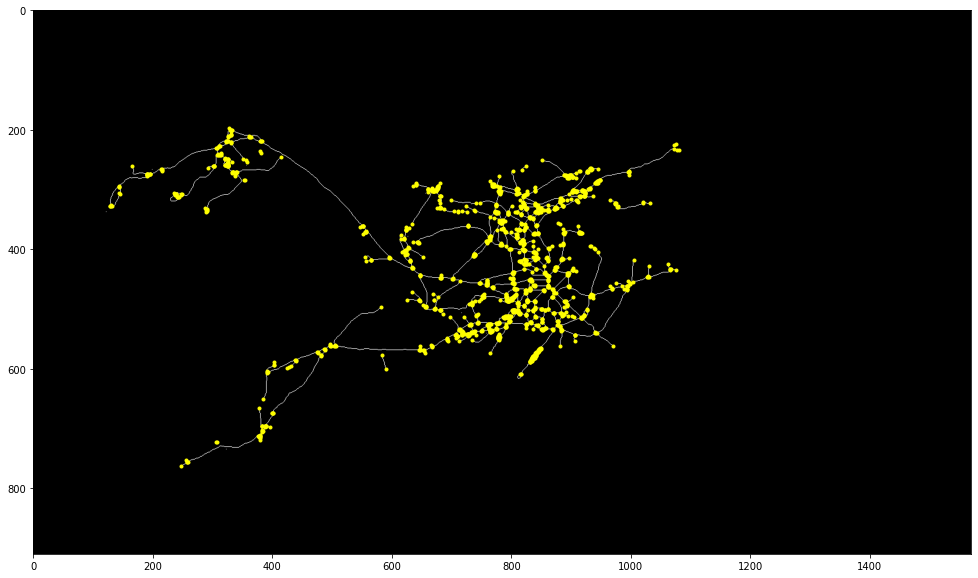

In [59]:
fig, ax = plt.subplots()
ax.imshow(skel, cmap=plt.cm.gray)
ax.plot(nodes[:, 1], nodes[:, 0], color='yellow', marker='o',
        linestyle='None', markersize=3)
plt.show()

In [60]:
final = trace_all_paths(skel, juncs)

100%|██████████| 1555/1555 [00:02<00:00, 568.09it/s]


In [61]:
final[1]

[array([200, 329]), array([197, 327]), 3.8284271247461903]

In [62]:
# (x0, y0), (x1, y1)
from matplotlib.collections import LineCollection
edges = [[[x[0][1], x[0][0]], [x[1][1], x[1][0]]] for x in final]
line_segments = LineCollection(edges)

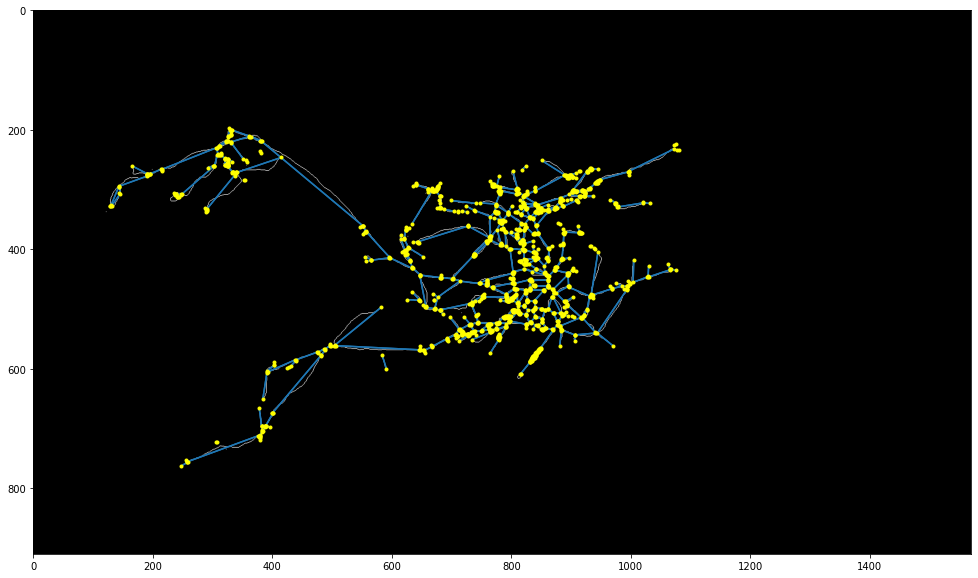

In [63]:
fig, ax = plt.subplots()
ax.imshow(skel, cmap=plt.cm.gray)
ax.plot(nodes[:, 1], nodes[:, 0], color='yellow', marker='o',
        linestyle='None', markersize=3)
ax.add_collection(line_segments)
plt.show()

- ~Change distance calc to include root 2 for diags~
- ~fix cycle bug~
- ~calc difference between pixel traversal distance and direct straight line distance~
- Look at iteratively collapsing connected juncs.

In [64]:
# final

In [65]:
def clean_joins(edges, min_distance=0):
    # Remove duplicates
    # This is slow and could definitely be quicker
    testset = set()
    outlist = []
    for x in edges:
#         print(str(x[0]) + str(x[1]))
        if str(x[0]) + str(x[1]) in testset or str(x[1]) + str(x[0]) in testset:
            next
        else:
            if x[2] >= min_distance:
                outlist.append(x)
                testset.add(str(x[0]) + str(x[1]))
    return outlist
cleaned_final = clean_joins(final, 2)
len(cleaned_final)

562

In [66]:
%%timeit
clean_joins(final, 2)

514 ms ± 50.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
# def remove_duplicate_joins(edges):
#     edgeunzip = [[*x[0],*x[1],x[2]] for x in edges]
#     for i, x in enumerate(edgeunzip):
#         if x[0] * x[1] > x[2] * x[3]:
#             edgeunzip[i] = [x[2], x[3], x[0], x[1], x[4]]
#     edgeunzip = np.array([np.array(x) for x in edgeunzip], dtype=str)
#     return np.unique(edgeunzip, axis=0)
# cleaned_final = remove_duplicate_joins(final)
# len(cleaned_final)

In [68]:
def find_length_difference(edges, return_only_diff=False):
    # By default returns edge array with linear distance and distance difference appended to each sublist.
    edgeunzip = [[*x[0],*x[1],x[2]] for x in edges]
    for x in edgeunzip:
        lindist = np.sqrt((x[0] - x[2])**2 + (x[1] - x[3])**2)
        x.append(lindist)
        x.append(abs(x[4] - lindist))
    if return_only_diff:
        return[x[6] for x in edgeunzip]
    else:
        return [[np.array(x[0:2]), np.array(x[2:4]), *x[4:]] for x in edgeunzip]
lendiffs = find_length_difference(cleaned_final, True)
# find_length_difference(cleaned_final)

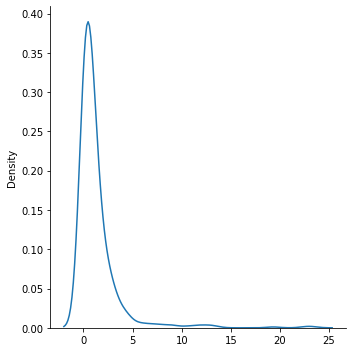

In [69]:
from seaborn import displot
displot(lendiffs, kind="kde")

## Looks like it's refactor time

In [70]:
juncs[0]

[array([197, 327]),
 array([[False, False, False],
        [False, False, False],
        [False,  True, False]]),
 1,
 ['S']]

In [71]:
class NJANode:
    def __init__(self, pos, surround=None, juncs=None, dirs=None, uid=None):
        self.position = pos
        self.surround = surround
        self.juncs = juncs
        self.dirs = dirs
        if uid is not None:
            self.uid = uid
        else:
            self.uid = tuple(self.position)
        self.connected_edges = {}

    def __repr__(self):
        return f"{self.__class__.__name__}({self.position}, {self.uid}, {self.surround}, {self.juncs}, {self.dirs})"
        
    def __str__(self):
        return f"UID:{self.uid}\n{self.__class__.__name__} @ {self.position}\nSurround:\n{self.format_surround(self.surround)}\nJunctions:{self.juncs}\nDirections:{self.dirs})"
    
    @property
    def flipped_position(self):
        # for plotting
        return [self.position[1], self.position[0]]
    
    @property
    def connected_edge_uids(self):
        return tuple(self.connected_edges.keys())
    
    def find_directions(self, dirdict=None):
        # Requires dirs to be initialised
        if dirdict is None:
            dirdict = dirs
        self.dirs = list(dirdict[np.flatnonzero(self.surround)])
        
    def reset_connected(self):
        self.connected_edges = {}
        
    @staticmethod
    def format_surround(submat, off="⬛", on="🟧", here="🟥"):
        formatted = np.repeat([off],9).reshape([3,3])
        formatted[submat] = on
        formatted[1,1] = here
        formatted = "\n".join(["".join(x) for x in formatted])
        return formatted

class NJAEdge:
    def __init__(self, start, end, uid=None, pixel_length=None, direct_length=None, path=None):
        self.start = start
        self.end = end
        if uid is not None:
            self.uid = uid
        else:
            self.uid = start.uid + end.uid
        self.pixel_length = pixel_length
        if direct_length is not None:
            self.direct_length = direct_length
        else:
            self.calc_direct_length()
        self.length_difference = None
        self.path = path
        try:
            self.calc_length_difference()
        except TypeError:
            pass
        
    def __repr__(self):
        return f"{__class__.__name__}({repr(self.start)}, {repr(self.end)},{self.uid}, {self.pixel_length}, {self.direct_length}, {self.path})"
    
    def __str__(self):
        return f"UID:{self.uid}\n{self.__class__.__name__}\n{repr(self.start.uid)}->{repr(self.end.uid)}\nPixel Length: {self.pixel_length}\nDirect Length: {self.direct_length}\nLength Difference: {self.length_difference}"
    
    @property
    def plotting_repr(self):
        return [self.start.flipped_position, self.end.flipped_position]
    
    @property
    def connected_node_uids(self):
        return self.start.uid, self.end.uid
    
    def calc_direct_length(self):
        # self.direct_length = np.sqrt((self.start.position[0] - self.end.position[0])**2 + (self.start.position[1] - self.end.position[1])**2)
        # Same as above as the L2 norm (ord=2) is the same as the euclidian distance.
        self.direct_length = np.linalg.norm(self.start.position - self.end.position, ord=2, axis=0)
        return self
    
    def calc_length_difference(self):
        self.calc_direct_length()
        self.length_difference = abs(self.pixel_length - self.direct_length)
        return self
    
    def format_journey(self):
        if self.path is None:
            print(f"No path trace detected in edge {self.uid}")
            return None
        path = self.path
        ymin = path[:,0].min()
        ymax = path[:,0].max()
        xmin = path[:,1].min()
        xmax = path[:,1].max()
        dims = [(ymax-ymin) + 1, (xmax-xmin) + 1]
        newpath = deepcopy(path) - np.array([ymin,xmin])
        output = np.repeat("⬛", dims[0] * dims[1]).reshape(dims)
        for x in newpath:
            output[x[0], x[1]] = "🟧"
        output[newpath[0][0], newpath[0][1]] = "🟩"
        output[newpath[-1][0], newpath[-1][1]] = "🟥"
        formatted = "\n".join(["".join(x) for x in output])
        return formatted
    
    def print_journey(self):
        print(self.format_journey())        

In [72]:
print(NJANode(*juncs[1]))

UID:(200, 329)
NJANode @ [200 329]
Surround:
🟧⬛⬛
⬛🟥🟧
🟧⬛⬛
Junctions:3
Directions:['NW', 'E', 'SW'])


In [73]:
e = NJAEdge(NJANode(np.array([0,3])), NJANode(np.array([4,0])), pixel_length = 4)
print(e.format_journey())

No path trace detected in edge (0, 3, 4, 0)
None


**Nodes and Edges are passed by reference, so we don't have to worry so much about what happens when we update one**

In [74]:
# THIS IS AN OLD VERSION, SEE FURTHER DOWN FOR CURRENT VERSION!
class NJANet:
    def __init__(self, image):
        self.image = image
        self.skel = None
        self.nodes = {}
        self.edges = {}
        
#     def __repr__(self):
#         return f"{__class__.__name__}()"

    def __str__(self):
        return f"{self.__class__.__name__}\nNodes: {len(self.nodes)}\nEdges: {len(self.edges)}"
    
    def skeletonize(self):
        self.skel = skeletonize(self.image)
        return self
        
    def find_nodes(self):
        if self.skel is None:
            self.skeletonize()
        whitepx = np.transpose(self.skel.nonzero())
        
        for px in tqdm(whitepx, bar_format = "Finding Nodes: {l_bar}{bar}{r_bar}"):
            x = detect_junc(self.skel, *px, flatten=False)
            if x[1] > 0 and x[1] !=2:
                node = NJANode(px, *x)
                self.nodes[node.uid] = node
        return self
    
    def find_directions(self):
        for x in tqdm(self.nodes.values(), bar_format = " Finding Dirs: {l_bar}{bar}{r_bar}"):
            x.find_directions()
        return self
    
    def trace_paths(self):
    # This is slightly less consistent than doing it all in one LC, but way easier to debug
        outlist = []
        for x in tqdm(self.nodes.values(), bar_format = "Tracing Paths: {l_bar}{bar}{r_bar}"):
            # Loop through output directions
            for y in x.dirs:
                try:
                    # startpoint, direction, image, print_journey=False, return_journey=False
#                     traceout = trace_path(x, y, self.skel, return_journey=return_journey)
                    traceout = trace_path([x.position, x.surround, x.juncs, None], y, self.skel, return_journey=True)
#                     outlist.append([x[0], *traceout])
                    yuid = tuple(traceout[0])
                    self.edges[x.uid+yuid] = NJAEdge(x, self.nodes[yuid], uid=x.uid+yuid, pixel_length=traceout[1], direct_length=None, path=traceout[2])
                except ValueError as e:
                    # print(str(e))
                    # Honestly cycles don't matter, 
                    pass
        return self
    
    def clean_edges(self):
        cleandict = dict()
        for x in tqdm(self.edges, bar_format = "Cleaning Edgelist: {l_bar}{bar}{r_bar}"):
            if tuple([x[2], x[3], x[0], x[1]]) in cleandict:
                # Much more common
                # print(f"Already seen {x} reversed")
                pass
            elif x in cleandict:
                # print(f"Already seen {x}")
                pass
            else:
                cleandict[x] = self.edges[x]
        self.edges = cleandict
        self.link_nodes_to_edges()
        return self
    
    def link_nodes_to_edges(self, purge=False):
        if purge:
            for x in self.nodes.values():
                x.reset_connected()
        for edge in self.edges.values():
            edge.start.connected_edges[edge.uid] = edge
            edge.end.connected_edges[edge.uid] = edge
        return self
    
    def remove_edges_by_uid(self, uids):
        if len(uids) == 4:
            if all([isinstance(x, int) for x in uids]):
                uids = [uids]
        for uid in uids:
            del self.edges[uid]
        return self

    def remove_nodes_by_uid(self, uids):
        if len(uids) == 2:
            if all([isinstance(x, int) for x in uids]):
                uids = [uids]
        for uid in uids:
            del self.nodes[uid]
        return self
    
    def plot(self):
        fig, ax = plt.subplots()
        ax.imshow(skel, cmap=plt.cm.gray)
        
        if self.nodes:
            nodes = np.asarray([x.position for x in self.nodes.values()])
        ax.plot(nodes[:, 1], nodes[:, 0], color='yellow', marker='o',
                linestyle='None', markersize=3)
        if self.edges:
            edges = [x.plotting_repr for x in self.edges.values()]
            line_segments = LineCollection(edges)
            ax.add_collection(line_segments)
        plt.show()

Finding Nodes: 100%|██████████| 8159/8159 [00:00<00:00, 97943.96it/s]


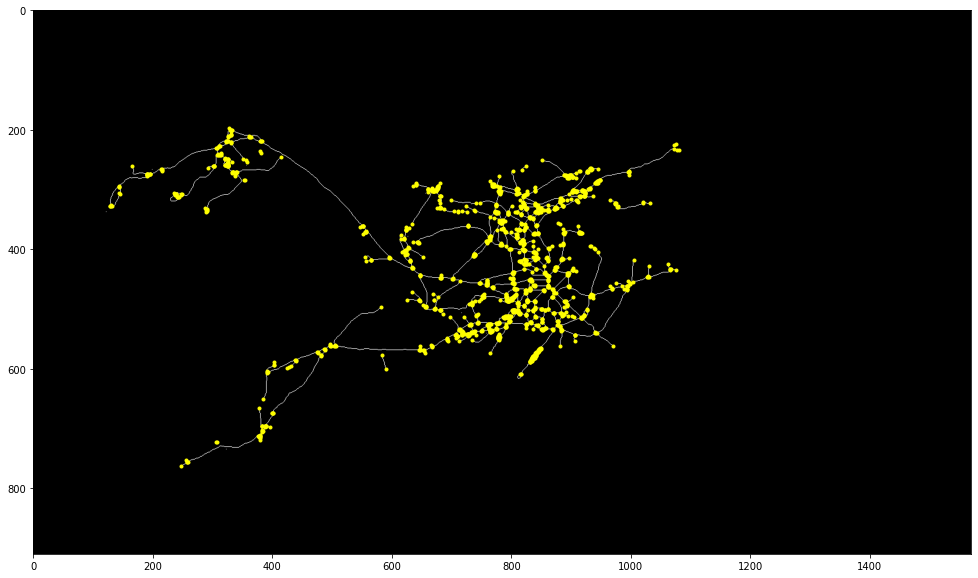

In [75]:
net = NJANet(testimage)
net = net.find_nodes()
net.plot()

In [76]:
net = net.find_directions()
net = net.trace_paths()

Tracing Paths: 100%|██████████| 1555/1555 [00:02<00:00, 755.01it/s]


In [77]:
net.edges[(18, 1319, 30, 1303)].print_journey()

KeyError: (18, 1319, 30, 1303)

In [ ]:
net.plot()

In [ ]:
# Pipeline test
net = NJANet(testimage)
net.skeletonize().find_nodes()
net = net.find_directions()
net = net.trace_paths().clean_edges()
net.link_nodes_to_edges()
net.plot()

In [ ]:
# %%timeit testnet=deepcopy(net)
# NJANet.clean_edges(testnet)

In [ ]:
test = [x for x in net.edges.values() if x.pixel_length < 2]
print(test[0])

In [ ]:
print(test[0].start.connected_edges.keys())

In [ ]:
candidateset = {x.start.uid for x in test}.union({x.end.uid for x in test})
list(candidateset)[0]

In [ ]:
def breadth_first(uid, candidates, net, threshold = 2, timeout = 100):
    finalset = set([uid])
    prevset = set([uid])
    counter = 0
    while True:
        counter += 1
        if counter > timeout:
            break
        newset = set()
        # For each node in previous set
        for nodeuid in prevset:
            # Get node
            workingnode = net.nodes[nodeuid]
            # For each edge on this node
            for edge in workingnode.connected_edges.values():
                # Add all connected nodes to newset if the edge pixel length is at or below set threshold
                if edge.pixel_length <= threshold:
                    newset = newset.union(edge.connected_node_uids)
        # Filter against candidate set (eliminate non-candidates)
        newset = candidates.intersection(newset)
        
        # Filter against previous set (eliminate any that are in previous)
        newset = newset.difference(prevset)
        # Filter against final set (eliminate any that are in final)
        newset = newset.difference(finalset)
        
        # Shift all the sets up one level
        # print("preshift", counter, len(newset), len(prevset), len(finalset))
        finalset = finalset.union(prevset)
        prevset = newset
        # print("postshift", counter, len(newset), len(prevset), len(finalset))
        
        if len(newset) <1:
            # If newset has nothing in it, we have nothing left to do
            break
    
    return finalset
breadth_first((423, 740), candidateset, net)

In [ ]:
candidateset = {x.start.uid for x in test}.union({x.end.uid for x in test})
grouped_candidates = []
try:
    while True:
        # Get a new uid
        uid = candidateset.pop()
        # Run breadth_first analysis to find all points reachable in jumps of 2 px or less
        cluster = breadth_first(uid, candidateset, net, 2, 100)
        # Remove all found points from candidate set as no matter where we start it should be the same cluster
        candidateset = candidateset.difference(cluster)
        grouped_candidates.append(cluster)
except KeyError:
    print(f"Done in {len(grouped_candidates)} runs")

In [ ]:
final_clusters = {}
for x in grouped_candidates:
    array = np.array(list(x))
    centroid = np.mean(array, axis=0)
    # Find the euclidian distance of each point from the centroid
    final = np.linalg.norm(array - centroid, ord=2, axis=1)
    # Get the point that is the closest
    closest = tuple(array[np.argmin(final), :])
    final_clusters[closest] = x.difference(set([closest]))
len(final_clusters)
# Final clusters are in the form (uid_closest_to_centroid):{uids_to_be_clustered}

## Next up
- Get new images from Hollie
- Test new images
- Create metrics output
- Create / automate still aquisition from pointcloud
- ???
- Profit!

In [ ]:
print(net)

In [ ]:
edges_to_purge = set()
nodes_to_purge = set()
# For each cluster
for keyuid, topurge in final_clusters.items():
    keynode = net.nodes[keyuid]
    # For each node uid to purge
    nodes_to_purge = nodes_to_purge.union(topurge)
    for purgeuid in topurge:
        # For each connected edge
        for euid, e in net.nodes[purgeuid].connected_edges.items():
            # Rebind start and endpoint
            if e.start.uid in topurge:
                e.start = keynode
            if e.end.uid in topurge:
                e.end = keynode
            if e.start.uid == e.end.uid:
                edges_to_purge.add(euid)
net.remove_edges_by_uid(edges_to_purge)
net.remove_nodes_by_uid(nodes_to_purge)
net.link_nodes_to_edges(purge=True)


In [ ]:
print(net)

In [ ]:
net.plot()

## Updated class place

In [ ]:
class NJANet:
    def __init__(self, image):
        self.image = image
        self.skel = None
        self.nodes = {}
        self.edges = {}

    def __str__(self):
        return f"{self.__class__.__name__}\nNodes: {len(self.nodes)}\nEdges: {len(self.edges)}"
    
    def skeletonize(self):
        self.skel = skeletonize(self.image)
        return self
        
    def find_nodes(self):
        if self.skel is None:
            self.skeletonize()
        whitepx = np.transpose(self.skel.nonzero())
        
        for px in tqdm(whitepx, bar_format = "Finding Nodes: {l_bar}{bar}{r_bar}"):
            x = detect_junc(self.skel, *px, flatten=False)
            if x[1] > 0 and x[1] !=2:
                node = NJANode(px, *x)
                self.nodes[node.uid] = node
        return self
    
    def find_directions(self):
        for x in tqdm(self.nodes.values(), bar_format = " Finding Dirs: {l_bar}{bar}{r_bar}"):
            x.find_directions()
        return self
    
    def trace_paths(self):
    # This is slightly less consistent than doing it all in one LC, but way easier to debug
        outlist = []
        for x in tqdm(self.nodes.values(), bar_format = "Tracing Paths: {l_bar}{bar}{r_bar}"):
            # Loop through output directions
            for y in x.dirs:
                try:
                    traceout = trace_path([x.position, x.surround, x.juncs, None], y, self.skel, return_journey=True)
                    yuid = tuple(traceout[0])
                    self.edges[x.uid+yuid] = NJAEdge(x, self.nodes[yuid], uid=x.uid+yuid, pixel_length=traceout[1], direct_length=None, path=traceout[2])
                except ValueError as e:
                    # Honestly cycles don't matter
#                     print(str(e))
                    pass
                except KeyError:
                    print(traceout)
                    print(x)
                    print(y)
                    raise
        return self
    
    def clean_edges(self):
        cleandict = dict()
        for x in tqdm(self.edges, bar_format = "Cleaning Edgelist: {l_bar}{bar}{r_bar}"):
            if tuple([x[2], x[3], x[0], x[1]]) in cleandict:
                # Much more common
                pass
            elif x in cleandict:
                pass
            else:
                cleandict[x] = self.edges[x]
        self.edges = cleandict
        self.link_nodes_to_edges()
        return self
    
    def link_nodes_to_edges(self, purge=False):
        if purge:
            for x in self.nodes.values():
                x.reset_connected()
        for edge in self.edges.values():
            edge.start.connected_edges[edge.uid] = edge
            edge.end.connected_edges[edge.uid] = edge
        return self
    
    def remove_edges_by_uid(self, uids):
        if len(uids) == 4:
            if all([isinstance(x, int) for x in uids]):
                uids = [uids]
        for uid in uids:
            del self.edges[uid]
        return self

    def remove_nodes_by_uid(self, uids):
        if len(uids) == 2:
            if all([isinstance(x, int) for x in uids]):
                uids = [uids]
        for uid in uids:
            del self.nodes[uid]
        return self
    
    def cluster_close_nodes(self, threshold=2, timeout=100):
        # Can only be run after link_nodes...
        thresholded_edges = [x for x in self.edges.values() if x.pixel_length <= threshold]
        candidateset = {x.start.uid for x in thresholded_edges}.union({x.end.uid for x in thresholded_edges})
        # Find 
        grouped_candidates = []
        try:
            while True:
                # Get a new uid
                uid = candidateset.pop()
                # Run breadth_first analysis to find all points reachable in jumps of 2 px or less
                cluster = breadth_first(uid, candidateset, self, threshold, timeout)
                # Remove all found points from candidate set as no matter where we start it should be the same cluster
                candidateset = candidateset.difference(cluster)
                grouped_candidates.append(cluster)
        except KeyError:
#             print(f"Done in {len(grouped_candidates)} runs")
            pass
        
        final_clusters = {}
        for x in grouped_candidates:
            array = np.array(list(x))
            centroid = np.mean(array, axis=0)
            # Find the euclidian distance of each point from the centroid
            final = np.linalg.norm(array - centroid, ord=2, axis=1)
            # Get the point that is the closest
            closest = tuple(array[np.argmin(final), :])
            final_clusters[closest] = x.difference(set([closest]))
        # Final clusters are in the form (uid_closest_to_centroid):{uids_to_be_clustered}
        
        edges_to_purge = set()
        nodes_to_purge = set()
        # For each cluster
        for keyuid, topurge in final_clusters.items():
            keynode = self.nodes[keyuid]
            # For each node uid to purge
            nodes_to_purge = nodes_to_purge.union(topurge)
            for purgeuid in topurge:
                # For each connected edge
                for euid, e in self.nodes[purgeuid].connected_edges.items():
                    # Rebind start and endpoint
                    if e.start.uid in topurge:
                        e.start = keynode
                    if e.end.uid in topurge:
                        e.end = keynode
                    if e.start.uid == e.end.uid:
                        edges_to_purge.add(euid)
        self.remove_edges_by_uid(edges_to_purge)
        self.remove_nodes_by_uid(nodes_to_purge)
        self.link_nodes_to_edges(purge=True)
        
        return self

    @staticmethod
    def fromimage(image):
        # Load from path if needed
        if isinstance(image, str):
            image = io.imread(image)[:,:,:3]
            image = (rgb2gray(image) > 0)
        
        net = NJANet(image)
        net = net.skeletonize().find_nodes()
        net = net.find_directions()
        net = net.trace_paths().clean_edges()
        net = net.link_nodes_to_edges()
#         net = net.cluster_close_nodes()
        return net
    
    def plot(self, plotoriginal=False):
        fig, ax = plt.subplots()
        if plotoriginal:
            ax.imshow(self.image, cmap=plt.cm.gray)
        else:
            ax.imshow(self.skel, cmap=plt.cm.gray)
        
        if self.nodes:
            nodes = np.asarray([x.position for x in self.nodes.values()])
            ax.plot(nodes[:, 1], nodes[:, 0], color='yellow', marker='o',
                    linestyle='None', markersize=3)
        if self.edges:
            edges = [x.plotting_repr for x in self.edges.values()]
            line_segments = LineCollection(edges)
            ax.add_collection(line_segments)
        plt.show()
        
    def plot_with_pixeldensity(self):
        gridsize = (1,7)
        fig = plt.figure(figsize=(18, 10))
        ax0 = plt.subplot2grid(gridsize, (0, 0), colspan=6, rowspan=1)
        ax1 = plt.subplot2grid(gridsize, (0, 6))
        
        ax0.imshow(self.image, cmap=plt.cm.gray)
        amt = np.mean(self.image, axis=1)
        depth = np.arange(0, self.image.shape[0])
        ax1.plot(amt, depth, color ="grey")
        ax1.invert_yaxis()
        ax1.axes.xaxis.set_ticks([])
        ax1.axes.yaxis.set_ticks([])
        ax1.set_frame_on(False)
        ax1.fill_betweenx(depth, amt,where=depth>=0, color='lightgrey')
        plt.show()
    
    def plot_with_nodedensity(self):
        gridsize = (1,7)
        fig = plt.figure(figsize=(18, 10))
        ax0 = plt.subplot2grid(gridsize, (0, 0), colspan=6, rowspan=1)
        ax1 = plt.subplot2grid(gridsize, (0, 6))
        nodedepth = np.asarray([x.position[0] for x in self.nodes.values() if x.juncs == 1])
        ax0.imshow(self.image, cmap=plt.cm.gray)
        if self.nodes:
            nodes = np.asarray([x.position for x in self.nodes.values()])
            ax0.plot(nodes[:, 1], nodes[:, 0], color='yellow', marker='o',
                    linestyle='None', markersize=3)
#         amt = np.mean(self.image, axis=1)
#         depth = np.arange(0, self.image.shape[0])
        sns.histplot(y=nodedepth, bins=100, kde=False, color="#aaaaaa", ax=ax1)
#         ax1.plot(amt, depth, color ="grey")
        ax1.set_ylim((0, self.image.shape[0]))
        ax1.invert_yaxis()
        ax1.axes.xaxis.set_ticks([])
        ax1.axes.yaxis.set_ticks([])
        ax1.set_frame_on(False)
#         plt.fill_betweenx(depth, amt,where=depth>=0, color='lightgrey')
        plt.show()

In [ ]:
net = NJANet.fromimage(testimage)

In [ ]:
print(net)

In [ ]:
net.cluster_close_nodes(10)

In [ ]:
net.plot_with_nodedensity()

In [ ]:
net.plot_with_pixeldensity()

In [ ]:
bottom = NJANet.fromimage("data/capturebottom.png")
top = NJANet.fromimage("data/capturetop.png")
front = NJANet.fromimage("data/capturefront.png")
side = NJANet.fromimage("data/captureside.png")

## Big question
When clustering nodes, is there something I should do to the pixel distance measurements?

**Also it seems like higher thresholds seem to give significantly coarser (but maybe more useful) metrics**

In [ ]:
bottom.plot()

In [ ]:
top.plot()

In [ ]:
front.plot(True)

In [ ]:
side.plot(True)

In [ ]:
net = NJANet.fromimage("data/capturefront.png")

In [ ]:
print(net)

In [ ]:
net.plot()

In [ ]:
net = net.cluster_close_nodes(10)

In [ ]:
print(net)

In [ ]:
net.plot(True)

In [ ]:
net.plot_with_pixeldensity()

In [ ]:
net.plot_with_nodedensity()

In [ ]:
print(len(net.nodes[(210, 327)].connected_edges))

In [ ]:
np.array(list(net.nodes))

In [ ]:
[np.min(np.array(list(net.nodes))[:,0]), np.min(np.array(list(net.nodes))[:,1])]

In [ ]:
[np.max(np.array(list(net.nodes))[:,0]), np.max(np.array(list(net.nodes))[:,1])]

In [ ]:
[np.mean(np.array(list(net.nodes))[:,0]), np.mean(np.array(list(net.nodes))[:,1])]

In [ ]:
[np.median(np.array(list(net.nodes))[:,0]), np.median(np.array(list(net.nodes))[:,1])]

## REASSIGN EDGE UID AND KEYS IN EDGEDICT AFTER COLLAPSING

In [ ]:
net.image.shape[0]
len(np.mean(net.image, axis=1))
len(np.arange(0, net.image.shape[0]))

In [ ]:
amt = np.mean(net.image, axis=1)
depth = np.arange(0, net.image.shape[0])

In [ ]:
plt.title("Line graph")
# plt.xlabel("X axis")
# plt.ylabel("Y axis")
plt.plot(depth, amt, color ="grey")
plt.fill_between(depth,amt,where=amt>=0, color='lightgrey')
plt.show()

In [ ]:
# import the packages
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

# set the figure size
# plt.rcParams["figure.figsize"] = [14.00, 7.0]
# plt.rcParams["figure.autolayout"] = True

# plot the figure
fig = plt.figure()
plt.plot(depth, amt, color ="grey")
plt.fill_between(depth,amt,where=amt>=0, color='lightgrey')
scales = (0, 5, 0, 5)

# Add 2D affine transformation
t = Affine2D().rotate_deg(25)

# Add floating axes
h = floating_axes.GridHelperCurveLinear(t, scales)
ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=h)

fig.add_subplot(ax)

plt.show()

In [ ]:
plt.plot(amt, depth, color ="grey")
# plt.fill_between(amt,depth,where=amt>=0, color='lightgrey')
plt.show()

In [ ]:
net.plot_with_pixeldensity()

## Next things to find
1. Length of first-order roots (i.e. ones branching out immediately from the base node)
2. Branch root depth density
3. Number of 1-nodes (root tips)
4. Distance of root tips (1-nodes) from base node (initially euclidean, but possibly pixel length too)
5. Max depth (distance from centre)
6. Gravitropism angle deviation of branches (I think normalised 